## Importing Dependincies

In [178]:
import pandas as pd 
import numpy as np
import datetime as dt
from collections import Counter

# Modeling
from sklearn.preprocessing import LabelEncoder
# !pip install xgboost
import xgboost as xgb
from sklearn.metrics import confusion_matrix

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

### Loading Dataset into enviroment

In [179]:
# Reading from csv
casino = pd.read_csv("Online_casino_DIB.csv")

# Create a copy of orginal
df = casino.copy()

df.head()

,ReqTimeUTC,TransactionType,TransactionAmount,Status,AccountIdentifier
0,2019-07-05T05:02:28+0000,LOYALTYCARDDEBIT,10.0,APPROVED,customer1734
1,2019-07-05T05:26:00+0000,LOYALTYCARDDEBIT,10.0,APPROVED,customer1734
2,2019-07-05T04:54:35+0000,LOYALTYCARDCREDITCL,10.0,APPROVED,customer1734
3,2019-07-05T05:02:27+0000,LOYALTYCARDCREDITCL,10.0,APPROVED,customer1734
4,2019-07-05T05:25:59+0000,LOYALTYCARDCREDITCL,10.0,APPROVED,customer1734


### Exploratory Data Analysis

- 1st column is a timestamp.

In [180]:
df.dtypes

ReqTimeUTC            object
TransactionType       object
TransactionAmount    float64
Status                object
AccountIdentifier     object
dtype: object

In [181]:
# Covert timestamp to datetime
df.ReqTimeUTC = pd.to_datetime(df.ReqTimeUTC)


In [182]:
df.describe(exclude = "float64").T # Describe with objects.

,count,unique,top,freq,mean,min,25%,50%,75%,max
ReqTimeUTC,138928,NaN,NaN,NaN,2019-08-23 14:37:01.511898112+00:00,2019-03-01 08:03:23+00:00,2019-05-19 06:27:26.249999872+00:00,2019-08-21 13:32:02.500000+00:00,2019-11-23 20:28:33.500000+00:00,2020-03-02 07:47:06+00:00
TransactionType,138928,3,LOYALTYCARDDEBIT,70329,NaN,NaN,NaN,NaN,NaN,NaN
Status,138928,2,APPROVED,133520,NaN,NaN,NaN,NaN,NaN,NaN
AccountIdentifier,138928,2361,customer10,2318,NaN,NaN,NaN,NaN,NaN,NaN


In [183]:
# Remove timestamps outside the range
df = df[df.ReqTimeUTC <= "2020-02-29 00:00:00+00:00"].copy()

In [184]:
# Checking unique values of a columnm
df.TransactionType.unique()

array(['LOYALTYCARDDEBIT', 'LOYALTYCARDCREDITCL', 'LOYALTYCARDCREDIT'],
      dtype=object)

#### Abbreviations came from dataset documentation.
- L2D = Level 2 deposits.
- L1D = Level 1 deposits made via a card or ACH respectively.
- l2W = Level 2 withdrawals

In [185]:
# Give new valuyes to df column
df.TransactionType = df.TransactionType.map({"LOYALTYCARDDEBIT": "L2D", "LOYALTYCARDCREDITCL": "L1D", "LOYALTYCARDCREDIT": "L2W"}) 


<Axes: xlabel='ReqTimeUTC', ylabel='Density'>

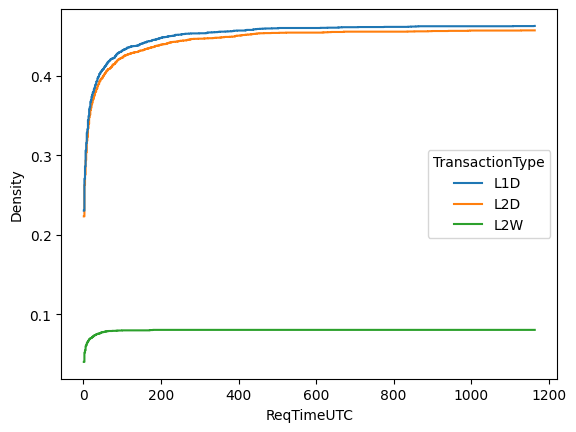

In [186]:
# Visualization.

user_type_ = df.groupby(["AccountIdentifier", "TransactionType"]).count().reset_index()

sns.histplot(data = user_type_, x="ReqTimeUTC", hue = "TransactionType", cumulative = True, stat="density", element="step", fill=False)




In [187]:
df = df[(df.TransactionType == "L2D")&(df.Status=="APPROVED")]

In [188]:
# Top 20 customers
top_20_freq = df.groupby("AccountIdentifier").count().reset_index().iloc[:, 0:2].sort_values("ReqTimeUTC")[::-1].head(20)

top_20_spenders = df[["AccountIdentifier", "TransactionAmount"]].groupby("AccountIdentifier").sum().reset_index().sort_values("TransactionAmount")[::-1].head(20)

<Axes: xlabel='TransactionAmount', ylabel='AccountIdentifier'>

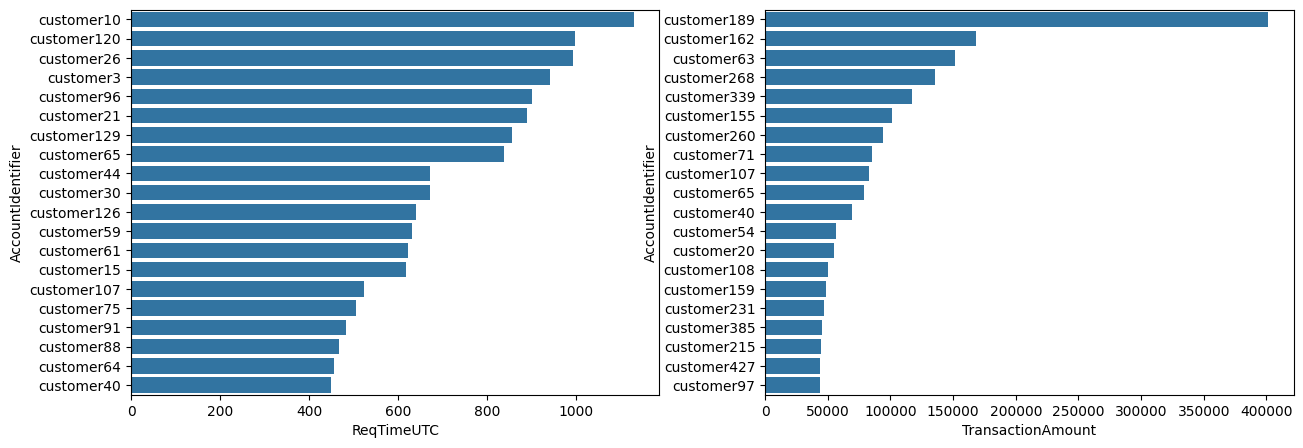

In [189]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5))

sns.barplot(top_20_freq, x = "ReqTimeUTC", y="AccountIdentifier", ax = ax[0])
sns.barplot(top_20_spenders, x = "TransactionAmount", y = "AccountIdentifier", ax=ax[1])

In [190]:
df["hour"] = df.ReqTimeUTC.dt.hour
df["day_of_week"] = df.ReqTimeUTC.dt.day_of_week


In [191]:
df["day_of_week"] = df["day_of_week"].map({0: "1_Monday", 1:"2_Tuesday", 2:"3_Wednesday",3:"4_Thursday",4:"5_Friday",5:"6_Saturday", 6:"7_Sunday"})

In [192]:
h_d_g =df[["hour", "day_of_week", "TransactionType"]].groupby(["hour", "day_of_week"]).count().reset_index()
df_hm = pd.pivot_table(h_d_g, values="TransactionType", index="day_of_week", columns="hour")

<Axes: xlabel='hour', ylabel='day_of_week'>

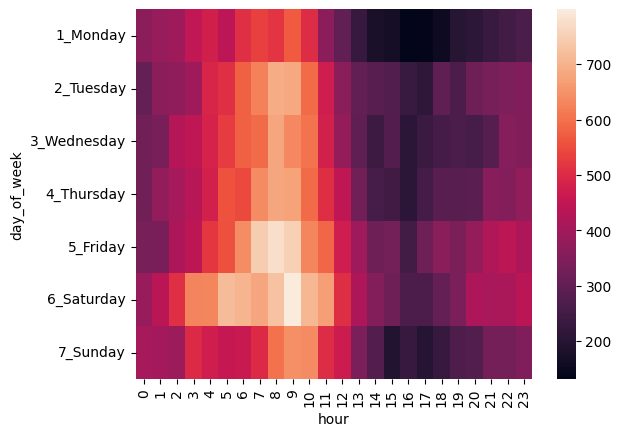

In [193]:
sns.heatmap(df_hm)

In [194]:
df["ReqDateUTC"] = df.ReqTimeUTC.dt.to_period("D")
df.groupby(["AccountIdentifier", "ReqDateUTC"]).agg({"TransactionAmount": "sum", "TransactionType":"count"})\
    .reset_index()

C:\Users\gulse\AppData\Local\Temp\ipykernel_142232\4159565072.py:1: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["ReqDateUTC"] = df.ReqTimeUTC.dt.to_period("D")


,AccountIdentifier,ReqDateUTC,TransactionAmount,TransactionType
0,customer1,2019-03-01,120.0,3
1,customer1,2019-03-02,125.0,2
2,customer1,2019-03-03,200.0,2
3,customer1,2019-03-04,160.0,3
4,customer1,2019-03-05,240.0,3
...,...,...,...,...
28600,customer996,2019-03-14,25.0,1
28601,customer996,2019-09-13,25.0,2
28602,customer997,2019-09-22,50.0,1
28603,customer998,2019-11-09,50.0,2


In [195]:
# Remove Single Value Columns
df = df[["AccountIdentifier", "ReqTimeUTC", "TransactionAmount"]]

# Sort df by columns
df = df.sort_values(["AccountIdentifier", "ReqTimeUTC"]).reset_index(drop=True)

# Rename Columns
df.rename(columns={"AccountIdentifier": "customer", "ReqTimeUTC": "timest", "TransactionAmount": "amount"}, inplace=True)

df.head()

,customer,timest,amount
0,customer1,2019-03-01 17:24:43+00:00,30.0
1,customer1,2019-03-01 19:54:04+00:00,50.0
2,customer1,2019-03-01 22:44:15+00:00,40.0
3,customer1,2019-03-02 02:44:20+00:00,100.0
4,customer1,2019-03-02 18:28:39+00:00,25.0


In [196]:
df.shape

(69734, 3)

#### Problem Framing

1. What could be answer to question "Will a customer purchase at least one in the next 3 days?"
2. Supervised/ Unsupervised? 
3. What Algorithms suitable?
4. What data do we need? (time-level: day)

#### Feature Engineering 

In [197]:
df["day"] = df.timest.dt.floor("D") # Day Level
daily_activity = df.groupby(["customer", "day"]).agg({"amount": ["sum", "count"]}).reset_index()
daily_activity = daily_activity.droplevel(axis = 1, level=1)
daily_activity.columns = ["customer", "day", "daily_amount", "nr_trans"]
daily_activity.head()

,customer,day,daily_amount,nr_trans
0,customer1,2019-03-01 00:00:00+00:00,120.0,3
1,customer1,2019-03-02 00:00:00+00:00,125.0,2
2,customer1,2019-03-03 00:00:00+00:00,200.0,2
3,customer1,2019-03-04 00:00:00+00:00,160.0,3
4,customer1,2019-03-05 00:00:00+00:00,240.0,3


In [198]:
# Does customer purchase everyday? Logically No.

df[df.customer == "customer1"][20:32]

,customer,timest,amount,day
20,customer1,2019-03-08 17:32:12+00:00,100.0,2019-03-08 00:00:00+00:00
21,customer1,2019-03-09 04:47:25+00:00,100.0,2019-03-09 00:00:00+00:00
22,customer1,2019-03-09 18:17:35+00:00,60.0,2019-03-09 00:00:00+00:00
23,customer1,2019-03-09 19:12:47+00:00,40.0,2019-03-09 00:00:00+00:00
24,customer1,2019-03-15 14:16:05+00:00,25.0,2019-03-15 00:00:00+00:00
25,customer1,2019-03-15 15:30:53+00:00,30.0,2019-03-15 00:00:00+00:00
26,customer1,2019-03-15 22:25:57+00:00,30.0,2019-03-15 00:00:00+00:00
27,customer1,2019-03-16 18:35:41+00:00,25.0,2019-03-16 00:00:00+00:00
28,customer1,2019-03-17 03:10:51+00:00,20.0,2019-03-17 00:00:00+00:00
29,customer1,2019-03-17 14:50:08+00:00,15.0,2019-03-17 00:00:00+00:00


In [199]:
full_customer = pd.DataFrame()
customer_ids = daily_activity.customer.unique()
len(customer_ids)

for customer in customer_ids:
    customer_df = daily_activity[daily_activity.customer == customer]
    customer_full_date_range = pd.date_range(
        customer_df.day.min(), 
        customer_df.day.max(),
        freq="D"
    )
    
    customer_df = customer_df.set_index(keys="day").copy()
    customer_df = customer_df.reindex(list(customer_full_date_range), fill_value=0)
    customer_df["customer"] = [customer]*len(customer_df)
    customer_df = customer_df.reset_index()
    
    full_customer = pd.concat([full_customer, customer_df]) 

full_customer = full_customer.reset_index(drop=True)
print(len(full_customer))
    

164656


In [202]:
ml_df = pd.DataFrame()

for customer in customer_ids:

    customer_df = full_customer[full_customer.customer == customer]
    customer_df = customer_df.reset_index(drop = True)

    features = []
    responses = []

    x1, x14, y = 0, 14, 17

    while y <= len(customer_df):

        # Base
        feat_x1_x14 = customer_df.nr_trans[x1: x14].values.tolist()
        trans_next_3_days = np.count_nonzero(customer_df.nr_trans[x14: y])
        response = [1 if trans_next_3_days != 0 else 0][0]
        responses.append(response)

        # Additional Infos
        
        # Deposit in the last 14 days
        x15 = np.count_nonzero(customer_df.nr_trans[x1: x14])

        # Deposit in the last 7 days
        x16 = np.count_nonzero(customer_df.nr_trans[x1+7: x14])

        # In the last 3 days
        x17 = np.count_nonzero(customer_df.nr_trans[x14-2: x14+1])

        # Average number of deposits in the last 14 day
        x18 = customer_df.nr_trans[x1: x14].mean().tolist()
        
        # Max daily deposit in the last 7 day
        x19 = customer_df.nr_trans[x1+7: x14].max().tolist()
        
        x20 = customer_df.daily_amount[x1+7: x14].sum().tolist()

        x21 = customer_df.daily_amount[x1+7: x14].mean().tolist()

        feat_x1_x14.extend([x15, x16, x17, x18, x19, x20, x21, customer])
        features.append(feat_x1_x14)
        # Increment
        x1 += 1
        x14 += 1
        y += 1


    
    df = pd.DataFrame(features)
    df["response"] = responses
    ml_df = pd.concat([ml_df, df])

In [203]:
ml_df.head()

,0,1,2,3,4,5,6,7,8,9,...,13,14,15,16,17,18,19,20,21,response
0,3.0,2.0,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,...,0.0,9.0,2.0,1.0,1.714286,3.0,400.0,57.142857,customer1,1.0
1,2.0,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,...,3.0,9.0,2.0,2.0,1.714286,3.0,285.0,40.714286,customer1,1.0
2,2.0,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,...,1.0,9.0,2.0,3.0,1.642857,3.0,110.0,15.714286,customer1,1.0
3,3.0,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,...,2.0,9.0,3.0,2.0,1.642857,3.0,145.0,20.714286,customer1,0.0
4,3.0,4.0,2.0,2.0,3.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,3.0,1.0,1.428571,3.0,145.0,20.714286,customer1,0.0


#### Train Test Split

In [204]:
ml_df = ml_df.drop_duplicates(subset=list(range(20))).reset_index(drop=True)

In [205]:
le = LabelEncoder()
ml_df.response = le.fit_transform(ml_df.response)

In [208]:
Counter(ml_df.response) # Balanced Data Set.
balanced_df = ml_df

In [210]:
# Split by customer id to perevent data leakage

split_df = balanced_df.iloc[:, [21, 22]].groupby(21).count().reset_index()
test_customer = list(split_df.sample(frac=.2)[21])

In [212]:
test_df = balanced_df[balanced_df[21].isin(test_customer)]
train_df = balanced_df[~balanced_df[21].isin(test_customer)]

print(Counter(train_df.response))
print(Counter(test_df.response))

Counter({1: 24381, 0: 18385})
Counter({1: 7153, 0: 4316})


In [213]:
x_train, x_test, y_train, y_test = train_df.iloc[:, :21], test_df.iloc[:, :21], train_df.response, test_df.response

In [214]:
# Training the model

xgb_classifier = xgb.XGBClassifier(eta = 0.05)
xgb_classifier.fit(x_train, y_train)

print(xgb_classifier.score(x_train, y_train))
print(xgb_classifier.score(x_test, y_test))

0.7917972220923163
0.7860319121109076


#### Metrics

In [215]:
# Predict

pred_labels = xgb_classifier.predict(x_test)
confusion_matrix(y_true=y_test, y_pred=pred_labels)

array([[3770,  546],
       [1908, 5245]], dtype=int64)

In [217]:
tn, fp, fn, tp = confusion_matrix(y_true=y_test, y_pred=pred_labels).ravel()

recall = tp/(tp+fn)
precision = tp/(tp+fp)

false_negative_rate = fn/(tp+fn)

print("Accuracy is: ", ((tp+tn)/len(y_test)))
print("Precision is: ", precision)
print("Recall is: ", recall)
print("Miss rate is: ", false_negative_rate)

Accuracy is:  0.7860319121109076
Precision is:  0.9057157658435503
Recall is:  0.733258772542989
Miss rate is:  0.26674122745701107
